Text(0.5, 47.04444444444444, '$t, время$')

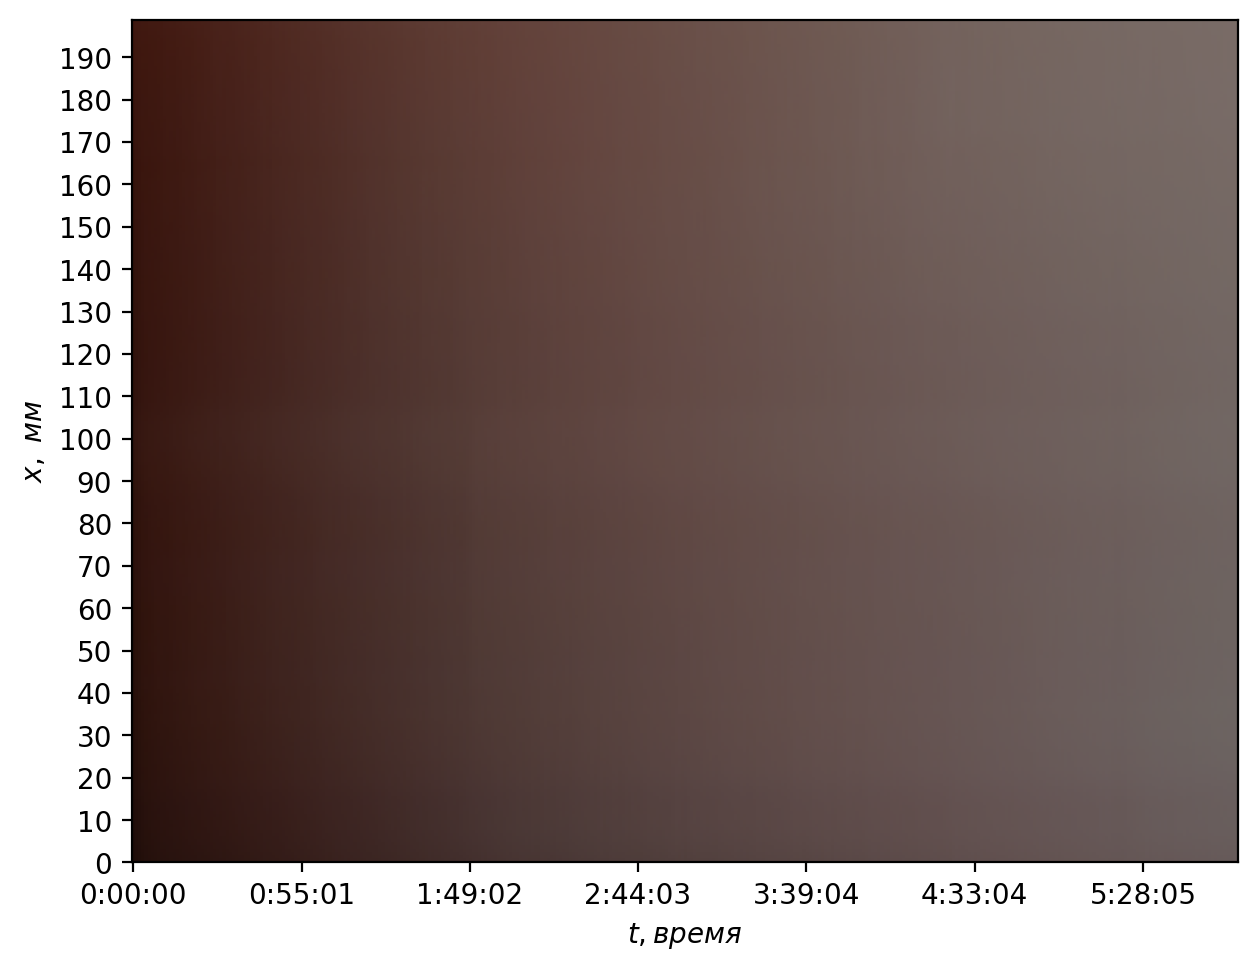

In [1]:
from common import *
import datetime
from matplotlib.colors import Normalize
import findiff
from random import randint
%matplotlib inline


PRE_PATH = ("data", "pre")

def extract_time(name):
    rsep = name.find('.')
    lsep = name.rfind('\\')
    return int(name[lsep + 1:rsep])

names, times = get_names(PRE_PATH, extract_time)

PX2TIME_COEFF = times[-1] / len(times) # s / pixel

res = cv2.imread(names[0])

for name in names[1:]:
    img = cv2.imread(name)
    res = np.concatenate((res, img), axis=1)

cv2.imwrite("scan.png", res)

display_img(res)

pxticks = range(0, res.shape[1], 54)
tticks = [str(datetime.timedelta(seconds=times[px])) for px in pxticks]

plt.xticks(pxticks, tticks)
plt.ylabel("$x, ~мм$")
plt.xlabel("$t, время$")


In [2]:
def calc_bnc_row(arr):
    h, _, _ = arr.shape

    maxval = 1e-6
    minval = 1e6

    clm = np.empty((h, 1), dtype=np.float64)
    for i, c in enumerate(arr):
        bnc = bgr2buoyancy(c[0])
        clm[i] = bnc
        
        maxval = max(maxval, bnc)
        minval = min(minval, bnc)

    return clm, minval, minval

def get_bnc_map(names):
    img = cv2.imread(names[0])
    res, minval, maxval = calc_bnc_row(img)

    for name in names[1:]:
        img = cv2.imread(name)
        bnc, minval_row, maxval_row = calc_bnc_row(img)
        res = np.concatenate((res, bnc), axis=1)

        minval = min(minval, minval_row)
        maxval = max(maxval, maxval_row)

    return res, minval, maxval

def xdiff(deriv, acc, map):
    h, w = map.shape
    
    dmap = np.full_like(map, np.nan)

    coeffs = findiff.coefficients(deriv=deriv, acc=acc)["center"]["coefficients"]
    span = len(coeffs) // 2

    dmax = -1e6
    dmin = 1e6

    for t in range(0, w):
        for x in range(span, h - span):
            slc = map[ x - span: x + span + 1, t]
            deriv = np.dot(slc.T, coeffs)
            dmap[x][t] = deriv / PX2MM_COEFF**deriv

            dmax = max(dmax, deriv)
            dmin = min(dmin, deriv)

    return dmap, dmin, dmax

def tdiff(deriv, acc, map):
    h, w = map.shape
    
    dmap = np.full_like(map, np.nan)

    coeffs = findiff.coefficients(deriv=deriv, acc=acc)["center"]["coefficients"]
    span = len(coeffs) // 2

    dmax = -1e6
    dmin = 1e6

    for x in range(0, h):
        for t in range(span, w - span):
            slc = map[ x, t - span: t + span + 1]
            deriv = np.dot(slc.T, coeffs)
            dmap[x][t] = deriv / PX2TIME_COEFF**deriv

            dmax = max(dmax, deriv)
            dmin = min(dmin, deriv)

    return dmap, dmin, dmax


def display_map(map, minval, maxval, title, cbartitle, inverted=False):
    map_display = np.empty_like(map, dtype=np.int32)

    h, w = map.shape

    for x in range(h):
        for t in range(w):
            val = map[x][t]

            if np.isnan(val):
                map_display[x][t] = randint(0, 255)
                continue

            norm = np.abs(val - minval) / (minval + maxval)
            
            if inverted: norm = 1 - norm
            
            map_display[x][t] = norm*255

    display_img(map_display, False)

    pxticks = range(0, res.shape[1], 54)
    tticks = [str(datetime.timedelta(seconds=times[px])) for px in pxticks]

    plt.xticks(pxticks, tticks)
    plt.ylabel("$x, ~мм$")
    plt.xlabel("$t, время$")

    plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(minval, maxval), cmap=plt.colormaps["viridis_r"]),
             label=cbartitle)

    plt.title(title)
    plt.show()


C:\Users\Vladimir\AppData\Local\Temp\ipykernel_23520\104415032.py:104: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(minval, maxval), cmap=plt.colormaps["viridis_r"]),


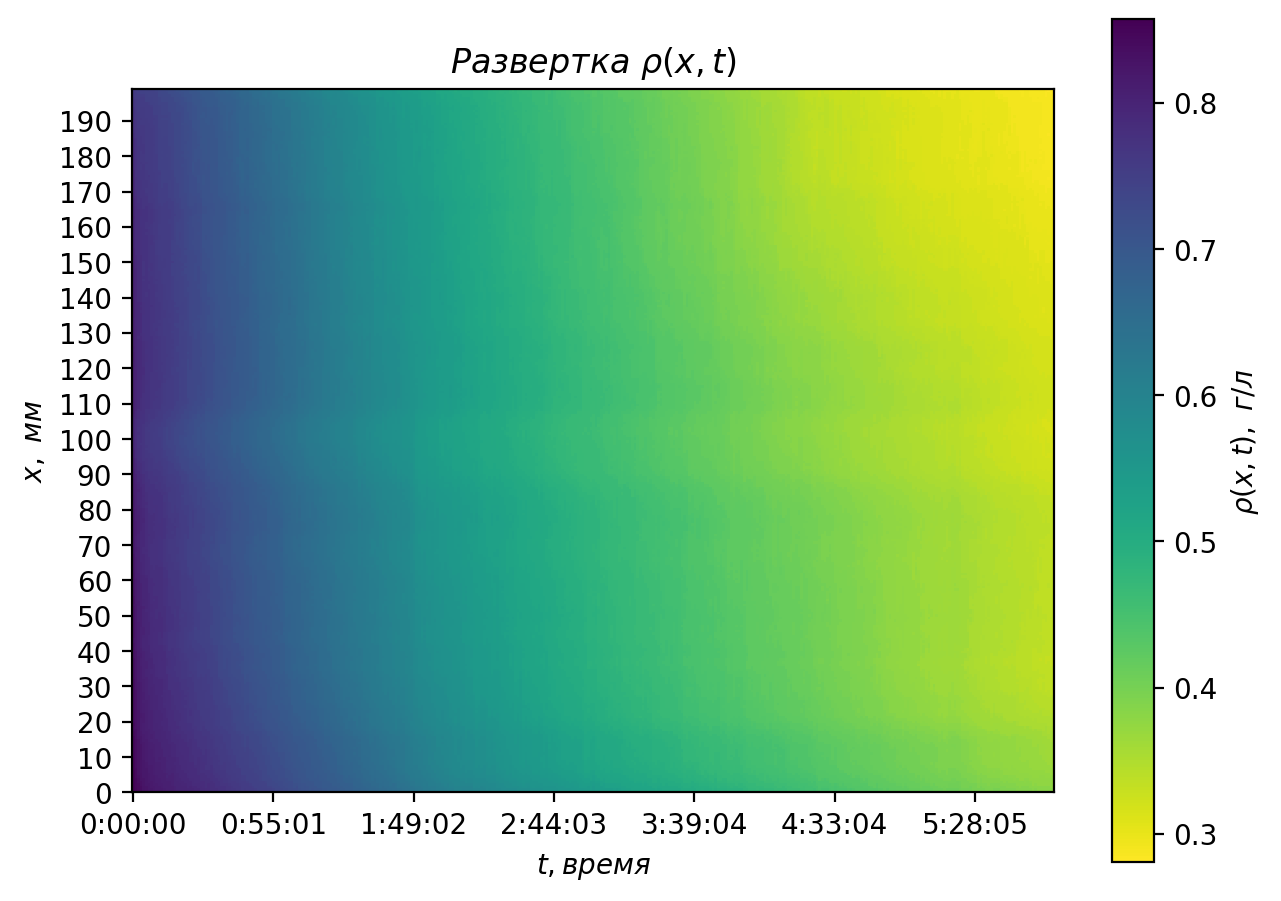

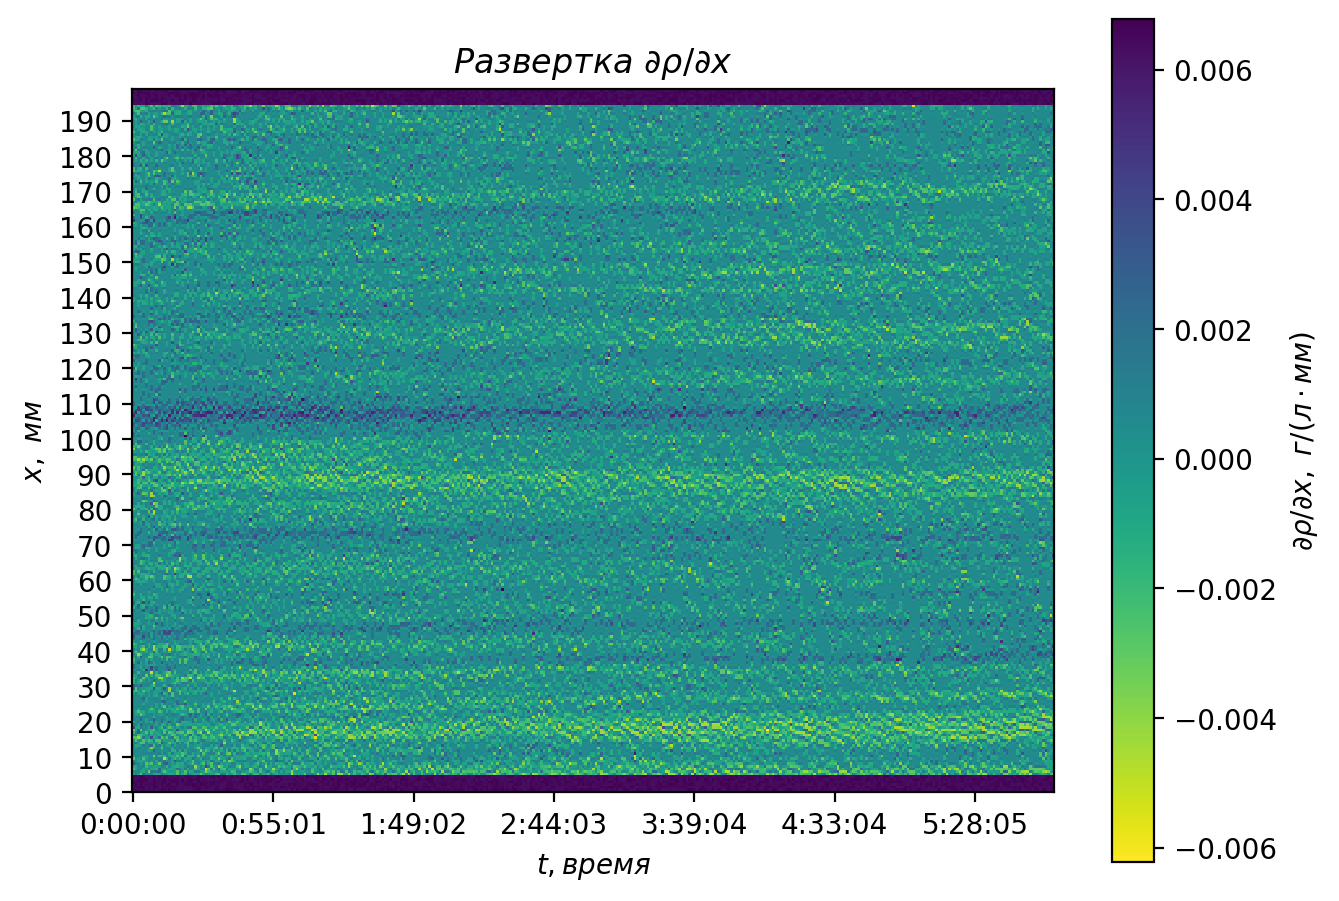

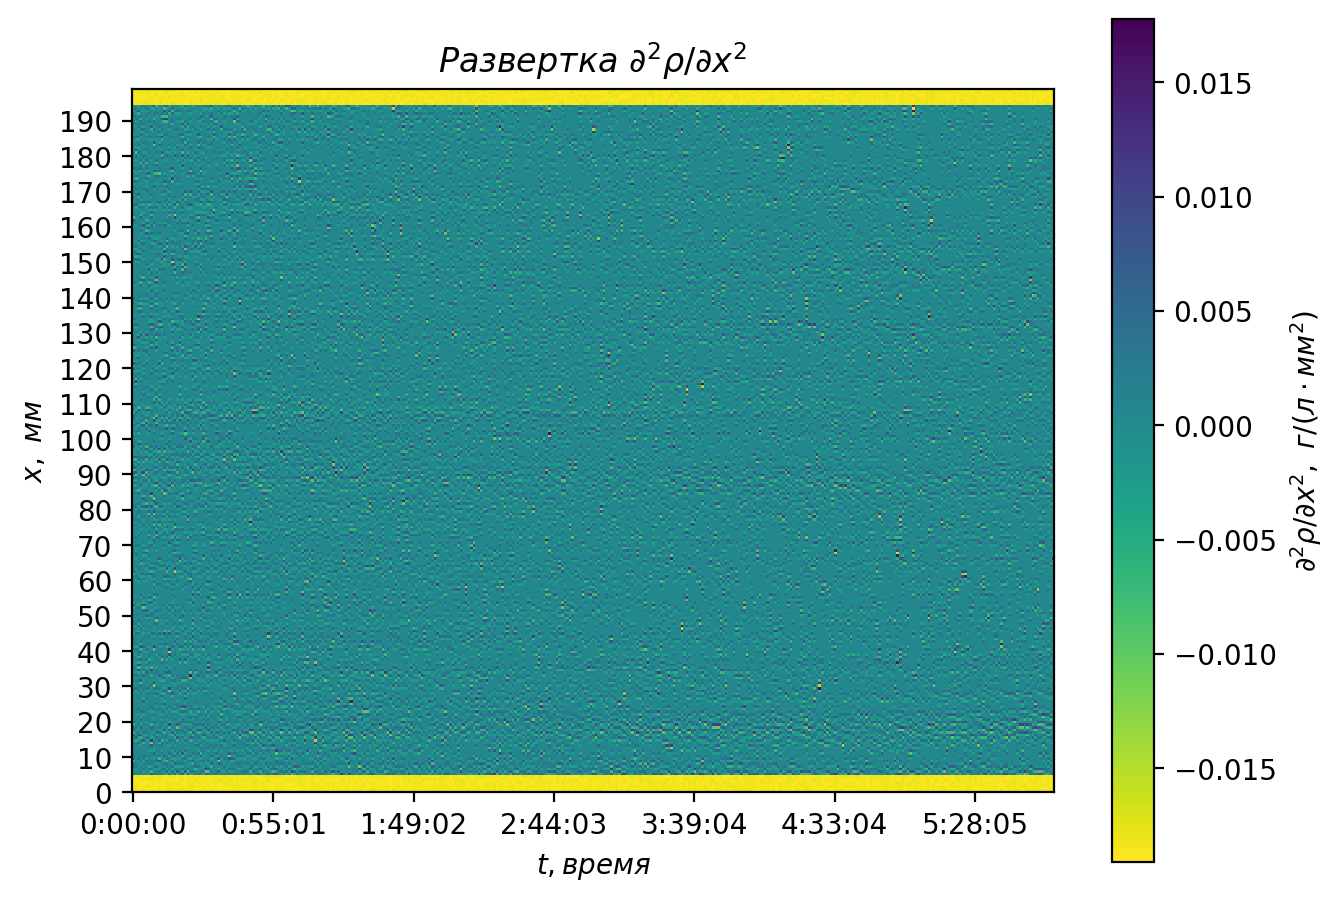

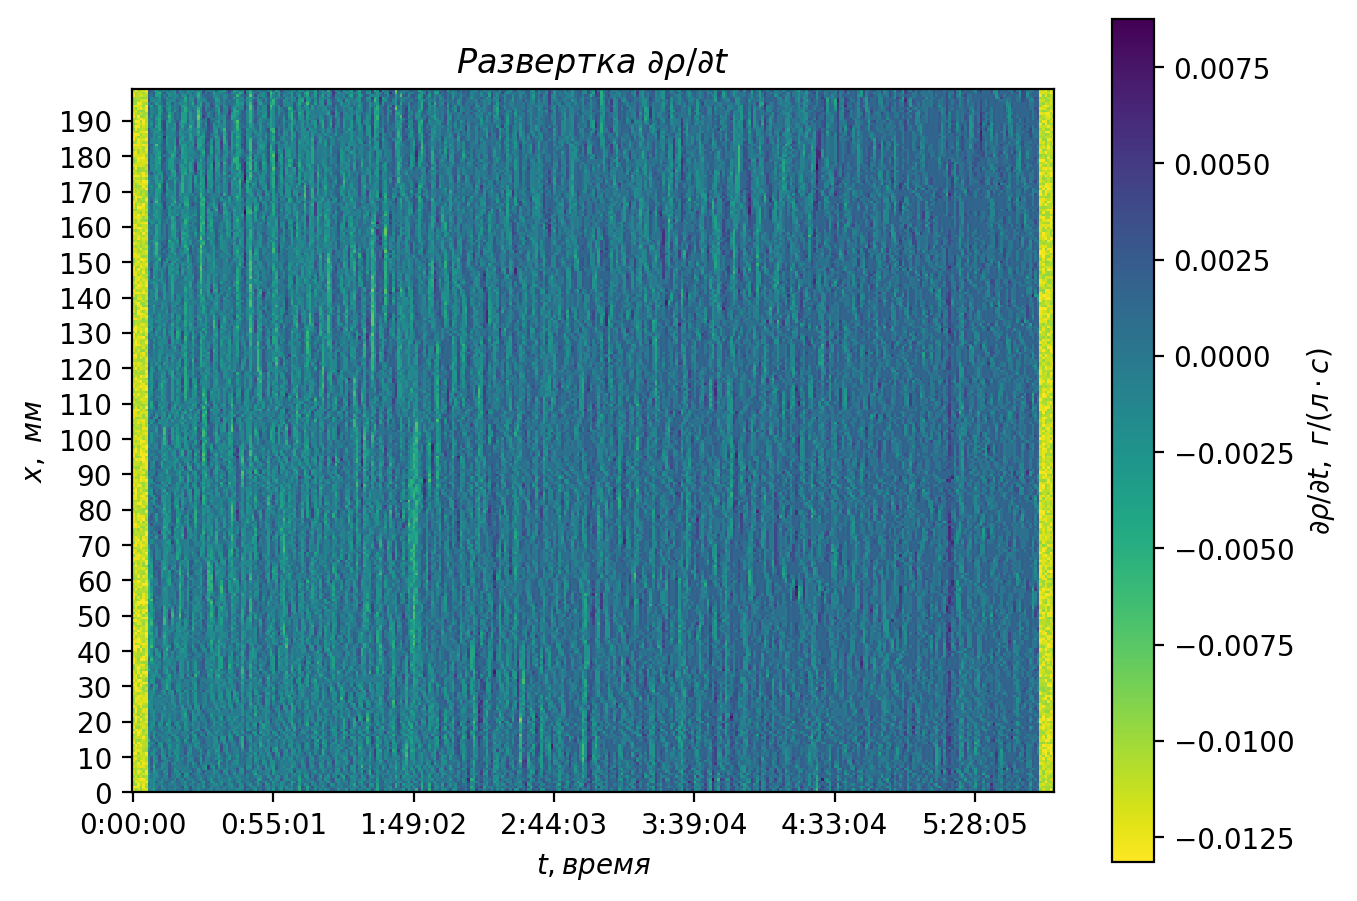

In [13]:
DERIV_ACC = 12

bncmap, bncmin, bncmax = get_bnc_map(names)
d1map, d1min, d1max = xdiff(1, DERIV_ACC, bncmap)
d2map, d2min, d2max = xdiff(2, DERIV_ACC, bncmap)
tmap, tmin, tmax = tdiff(1, DERIV_ACC, bncmap)

%matplotlib inline

display_map(bncmap, bncmin, bncmax, "$Развертка ~\\rho(x, t)$", 
                                    "$\\rho(x, t),~ г/л$", True)

display_map(d1map, d1min, d1max, "$Развертка ~\partial \\rho / \partial x$", 
                                 "$\partial \\rho / \partial x, ~г/(л \cdot мм)$")

display_map(d2map, d2min, d2max, "$Развертка ~\partial^2 \\rho / \partial x^2$",
                                 "$\partial^2 \\rho / \partial x^2, ~г/(л \cdot мм^2)$")

display_map(tmap, tmin, tmax, "$Развертка ~\partial \\rho / \partial t$",
                                 "$\partial \\rho / \partial t, ~г/(л \cdot c)$")



In [9]:
def flatten(maps):
    h, w = maps[0].shape
    
    arrs = np.full((len(maps), h*w), np.nan, dtype=maps[0].dtype)

    for i in range(h):
        for j in range(w):
            valid = True

            for map in maps:
                if np.isnan(map[i][j]):
                    valid = False
                    break
            
            if not valid: continue

            for k in range(len(maps)):
                arrs[k][i*h + j] = maps[k][i][j]

    return arrs

arrs = flatten((d1map, d2map, tmap))